In [1]:
# Access astronomical databases
from pyvo import registry

# Moc and HEALPix tools
from mocpy import MOC

# Sky visualization
from ipyaladin import Aladin

# For plots
import matplotlib.pyplot as plt

# Welcome to VizieR example workflow

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

It is a generic notebook, highlighting what can be done once you chose a catalog. This workflow is suggested by [CDS](https://cdsweb.unistra.fr/) (Strasbourg Astronomical Data Center, house of [VizieR](https://vizier.cds.unistra.fr/viz-bin/VizieR)).

--------------------------------------------------------

Modify the <a href='https://vizier.cds.unistra.fr'>VizieR catalogue</a> name (variable <b>CATALOGUE</b>) and anything else you might feel like exploring!

## 1. Setup

This example notebook has the following dependencies: 

**Required**
- pyvo : this library facilitates the access to the Virtual Observatory (VO) resources. VizieR is part of the VO.

**Optional, for visualization**
- ipyaladin : this is the Aladin-lite sky viewer, bundled as a jupyter widget. It allows to plot catalogs and multi-order coverages (MOC)
- matplotlib : an other option to see catalog points and MOCs

## 2. Metadata exploration with the Virtual Observatory registry

This part uses [pyvo](https://pyvo.readthedocs.io/en) to connect to the VO registry.

In [20]:
# the catalogue name in VizieR 
CATALOGUE = "J/ApJ/861/49"

We first retrieve catalogue information.

In [21]:
# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

In [22]:
# We can print metadata information about the catalogue
voresource.describe(verbose=True)

ALFALFA extragalactic HI source catalog
Short Name: J/ApJ/861/49
IVOA Identifier: ivo://cds.vizier/j/apj/861/49
Access modes: conesearch, tap#aux, web
Multi-capabilty service -- use get_service()

We present the catalog of ~31500 extragalactic HI line sources detected by the
completed Arecibo Legacy Fast ALFA (ALFALFA) survey out to z<0.06, including
both high signal-to-noise ratio (>6.5) detections and ones of lower quality
that coincide in both position and recessional velocity with galaxies of known
redshift. We review the observing technique, data reduction pipeline, and
catalog construction process, focusing on details of particular relevance to
understanding the catalog's compiled parameters. We further describe and make
available the digital HI line spectra associated with the cataloged sources.
In addition to the extragalactic HI line detections, we report nine confirmed
OH megamasers (OHMs) and 10 OHM candidates at 0.16<z<0.22 whose OH line
signals are redshifted into the ALFA

We can also inspect in details the `resource` object and access the attributes not provided by the describe method. See for example, the first author of a resource: 

In [23]:
voresource.creators[0]

'Haynes M.P.'

## 3. Access the tabular data of this catalog

We can have a look at the tables available in the catalogue.

In [24]:
tables = voresource.get_tables()
tables

{'J/ApJ/861/49/table3': <Table name="J/ApJ/861/49/table3">... 16 columns ...</Table>,
 'J/ApJ/861/49/table2': <Table name="J/ApJ/861/49/table2">... 25 columns ...</Table>}

In [25]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())
tables_names

['J/ApJ/861/49/table3', 'J/ApJ/861/49/table2']

The actual data can then be access using any of the ``access_modes`` of the voresource.

In [26]:
voresource.access_modes()

{'conesearch', 'tap#aux', 'web'}

The web access is found by following the ``reference_url``

In [27]:
voresource.reference_url

'https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJ/861/49'

### 3.1 Execute a SQL/ADQL query

The ``tap#aux`` in the ``access_mode`` response indicates that we can also do a SQL/ADQL query for these VizieR tables.

On the first table of the catalogue, we execute an <a href='https://www.ivoa.net/documents/latest/ADQL.html'>ADQL</a> query.

In [28]:
# get the first table of the catalogue
first_table_name = tables_names[0]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(
    f'select TOP 10 * from "{first_table_name}"',
)
tap_records

<Table length=10>
recno  AGC               Name                  RAJ2000            DEJ2000              RAO                DEO          Fcent   W50     HIflux    SNR     rms      z     f_AGC 
                                                 deg                deg                deg                deg           MHz   km / s Jy km / s           mJy                  
int32 int32             object                 float64            float64            float64            float64       float64 int16   float64  float64 float64 float64  object
----- ------ ---------------------------- ------------------ ------------------ ------------------ ------------------ ------- ------ --------- ------- ------- -------- ------
    1 114529     SDSS J015001.57+240235.8 27.507916666666663  24.03972222222222 27.506666666666664  24.04333333333333 1384.12    613      2.88     9.7    2.17 0.204368      a
    2 121379              IRAS 02524+2046  43.82416666666666  20.98833333333333  43.82124999999999 20.98249

<!-- section position -->

We will explore the other access modes here.

### 3.2. Execute a cone search query

We use the Simple Cone Search (<a href='https://www.ivoa.net/documents/latest/ConeSearch.html'>SCS</a>) protocol of the virtual observatory (only available for tables with positions).

Adapt the radius and position of the center to your needs.

In [31]:
conesearch_radius = 1 / 60.0  # in degrees
conesearch_center = (27.51, 24.04)

In [32]:
conesearch_records = voresource.get_service("conesearch").search(
    pos=conesearch_center,
    sr=conesearch_radius,
)
conesearch_records

<Table length=1>
 _RAJ2000   _DEJ2000     _r   recno  AGC             Name            RAJ2000    DEJ2000     RAO        DEO     Fcent   W50     HIflux    SNR     rms       z     f_AGC NED  LEDA
   deg        deg                                                                                               MHz   km / s Jy km / s           mJy                            
 float64    float64   float64 int32  str6           str28             str10       str9     str10       str9   float32 int16   float32  float32 float32  float64   str3 str3 str4
---------- ---------- ------- ----- ------ ------------------------ ---------- --------- ---------- --------- ------- ------ --------- ------- ------- --------- ----- ---- ----
 27.507917  24.039722 0.00192     1 114529 SDSS J015001.57+240235.8 01 50 01.9 +24 02 23 01 50 01.6 +24 02 36 1384.12    613      2.88     9.7    2.17  0.204368     a  NED LEDA

## 4. Get the catalogue coverage

VizieR also provides the coverage of each catalogue with Multiple Order Coverage (<a href='https://ivoa.net/documents/MOC/'>MOC</a>) at order 10 -- meaning with a 0.001 rad spacial resolution.

In [33]:
# retrieve the MOC
catalogue_coverage = MOC.from_fits(
    f"https://cdsarc.cds.unistra.fr/viz-bin/moc/{CATALOGUE}",
)
catalogue_coverage

10/29 147 190 209 297 307 312 547 652 703 706-707 818 937 946 1148 1164 1167 
 1236 1265 1328 1521 1592 1723 2005 2045 2123 2143 2167 2337 2362 2469 2474 
 2544 2547 2549 2552 2576 2641 2763 2783 2853 2884 2891 2964 3025 3035 3056 
 3076 3122 3141 3187 3280 3332 3337 3412 3539 3558 3603 3761 3797 3892 4029 
 4108 4234 4618 4638 4722 5023 6318 6491 6681 6885-6886 7012 7163 8203 8208 
 8375 8391 8455 8504 8538 8588 8593 8719 8752 8809-8810 8921 9001 9168 9198 
 9228 9247 9256 9312 9458 9518-9519 9569 9572 9574 9654 9692 9718 9733 9766 
 9903 10002 10034 10038 10073 10194 10241 10363 10567 11015 11044 11085 11117 
 11217 11403 11456 11469 11480 11529 11604 11606 11611 11614 11649 11693 11713 
 11870 11903 12094 12236 12386 12429 12432 12448 12462 12486 12506 12530 12543 
 12603 12633 12679 12891 12893 12901 12917-12918 12981 12986 12991 13000 13024 
 13030 13036 13064 14262 14371-14372 14388 14413 14482 14488 14493 14752 14864 
 14881 14912 14967 15101 15148 15221 15264 15603 15899 15912 

We can plot the coverage with ``matplotlib``.

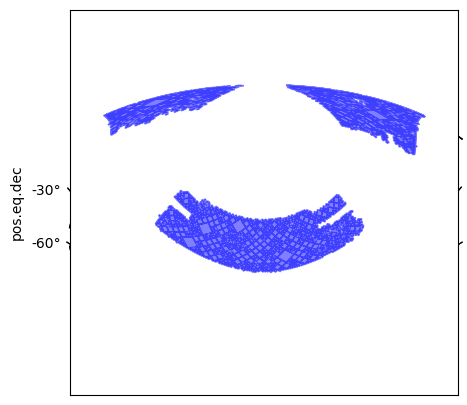

In [34]:
fig = plt.figure(figsize=(5, 5))
wcs = catalogue_coverage.wcs(fig)
ax = fig.add_subplot(projection=wcs)
catalogue_coverage.fill(ax=ax, wcs=wcs, alpha=0.5, color="blue")

or with ipyaladin

In [39]:
aladin = Aladin()
aladin

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

We can add the tables and coverage in this ipyaladin window.

In [40]:
aladin.add_table(conesearch_records.to_table())

In [41]:
aladin.add_table(tap_records.to_table())

In [42]:
aladin.add_moc_from_URL(
    f"https://cdsarc.cds.unistra.fr/viz-bin/moc/{CATALOGUE}",
    moc_options={"opacity": 0.5, "color": "pink"},
)

For more information about manipulating coverages, see [MOCpy documentation](https://cds-astro.github.io/mocpy/).

<!-- section assocdata -->

## 5. Query FITS spectra or images

VizieR __CATALOGUE__ contains spectra or images provided in the <a href='https://cdsarc.cds.unistra.fr/assocdata/'>VizieR associated data</a>.

The description and the FITS are available by TAP, using the VizieR <a href='The data are also available using ObsTAP.'>ObsTAP</a> service

In [43]:
# look for the Obscore TAP service of VizieR
obstap_service = registry.search("ObsTAP VizieR", registry.Servicetype("tap"))

# execute the query
fits_list = obstap_service[0].get_service("tap").run_sync(f"SELECT TOP 10 * FROM obscore WHERE obs_collection='{CATALOGUE}'")
print(fits_list)

<Table length=10>
access_estsize  access_format                                   access_url                                    bib_reference    calib_level dataproduct_type ... s_resolution target_name t_exptime  t_max   t_min  t_resolution
    kbyte                                                                                                                                                   ...    arcsec                                                      
    int64           object                                        object                                          object          int32         object      ...   float64       object    float64  float64 float64   float64   
-------------- ---------------- -------------------------------------------------------------------------- ------------------- ----------- ---------------- ... ------------ ----------- --------- ------- ------- ------------
         46080 application/fits https://cdsarc.cds.unistra.fr/saadavizier/download?oid